## Difference-in-Differences Estimation

`PyFixest` supports event study designs via the canonical two-way fixed effects design, the 2-Step imputation estimator, and local projections. 

See also [NBER SI methods lectures on Linear Panel Event Studies](https://www.nber.org/conferences/si-2023-methods-lectures-linear-panel-event-studies).

In [1]:
from importlib import resources

import pandas as pd

import pyfixest as pf
from pyfixest.report.utils import rename_event_study_coefs
from pyfixest.utils.dgps import get_sharkfin

%load_ext autoreload
%autoreload 2

In [2]:
# one-shot adoption data - parallel trends is true
df_one_cohort = get_sharkfin()
df_one_cohort.head()

,unit,year,treat,Y,ever_treated
0,0,0,0,1.629307,0
1,0,1,0,0.825902,0
2,0,2,0,0.208988,0
3,0,3,0,-0.244739,0
4,0,4,0,0.804665,0


In [3]:
# multi-cohort adoption data
df_multi_cohort = pd.read_csv(
    resources.files("pyfixest.did.data").joinpath("df_het.csv")
)
df_multi_cohort.head()

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
0,1,33,Group 2,7.043016,2010,1990,0.066159,False,-20.0,-6,-0.086466,0,0.0,7.022709
1,1,33,Group 2,7.043016,2010,1991,-0.030980,False,-19.0,-6,0.766593,0,0.0,7.778628
2,1,33,Group 2,7.043016,2010,1992,-0.119607,False,-18.0,-6,1.512968,0,0.0,8.436377
3,1,33,Group 2,7.043016,2010,1993,0.126321,False,-17.0,-6,0.021870,0,0.0,7.191207
4,1,33,Group 2,7.043016,2010,1994,-0.106921,False,-16.0,-6,-0.017603,0,0.0,6.918492


### Examining Treatment Timing

Before any DiD estimation, we need to examine the treatment timing, since it is crucial to our choice of estimator. 

<Axes: title={'center': 'Treatment Assignment Cohorts'}, xlabel='Year', ylabel='Cohort'>

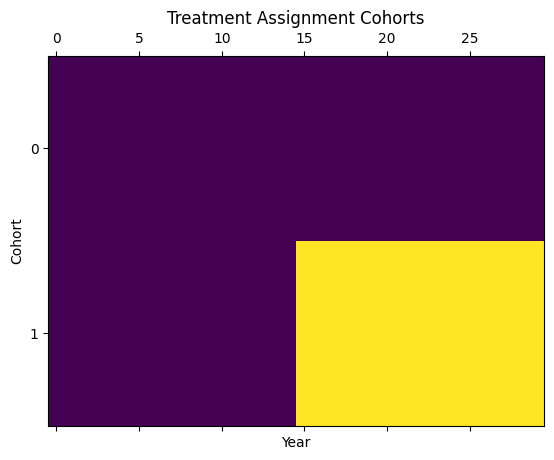

In [4]:
pf.panelview(
    df_one_cohort,
    unit="unit",
    time="year",
    treat="treat",
    collapse_to_cohort=True,
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Year",
    title="Treatment Assignment Cohorts",
)

<Axes: title={'center': 'Treatment Assignment Cohorts'}, xlabel='Year', ylabel='Cohort'>

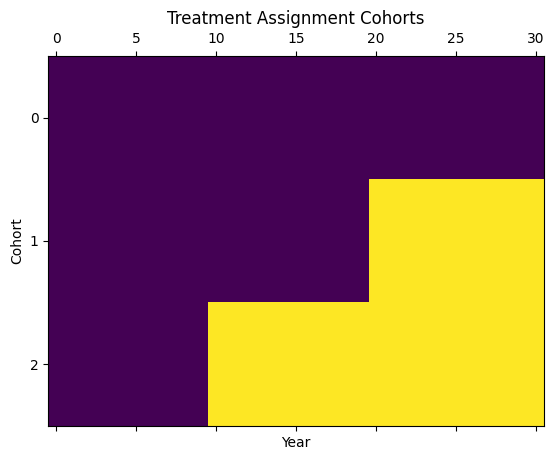

In [5]:
pf.panelview(
    df_multi_cohort,
    unit="unit",
    time="year",
    treat="treat",
    collapse_to_cohort=True,
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Year",
    title="Treatment Assignment Cohorts",
)

We immediately see that we have staggered adoption of treatment in the second case, which implies that a naive application of 2WFE might yield biased estimates under substantial effect heterogeneity.

We can also plot treatment assignment in a disaggregated fashion, which gives us a sense of cohort sizes.

<Axes: title={'center': 'Treatment Assignment (all units)'}, xlabel='Year', ylabel='Unit'>

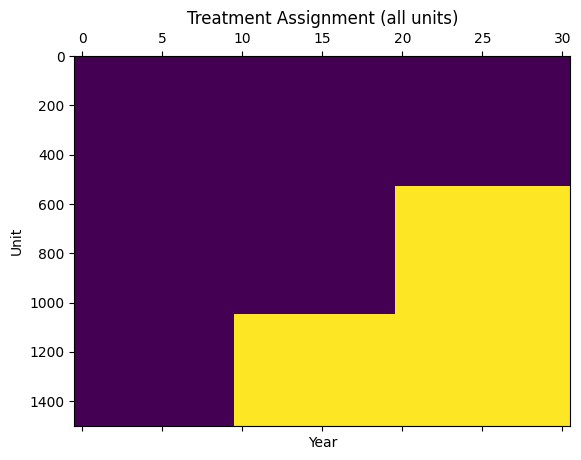

In [6]:
pf.panelview(
    df_multi_cohort,
    unit="unit",
    time="year",
    treat="treat",
    sort_by_timing=True,
    ylab="Unit",
    xlab="Year",
    title="Treatment Assignment (all units)",
)

`pf.panelview()` further allows us to inspect the "outcome" variable over time: 

<Axes: title={'center': 'Outcome over Time with Treatment Effect'}, xlabel='year', ylabel='dep_var'>

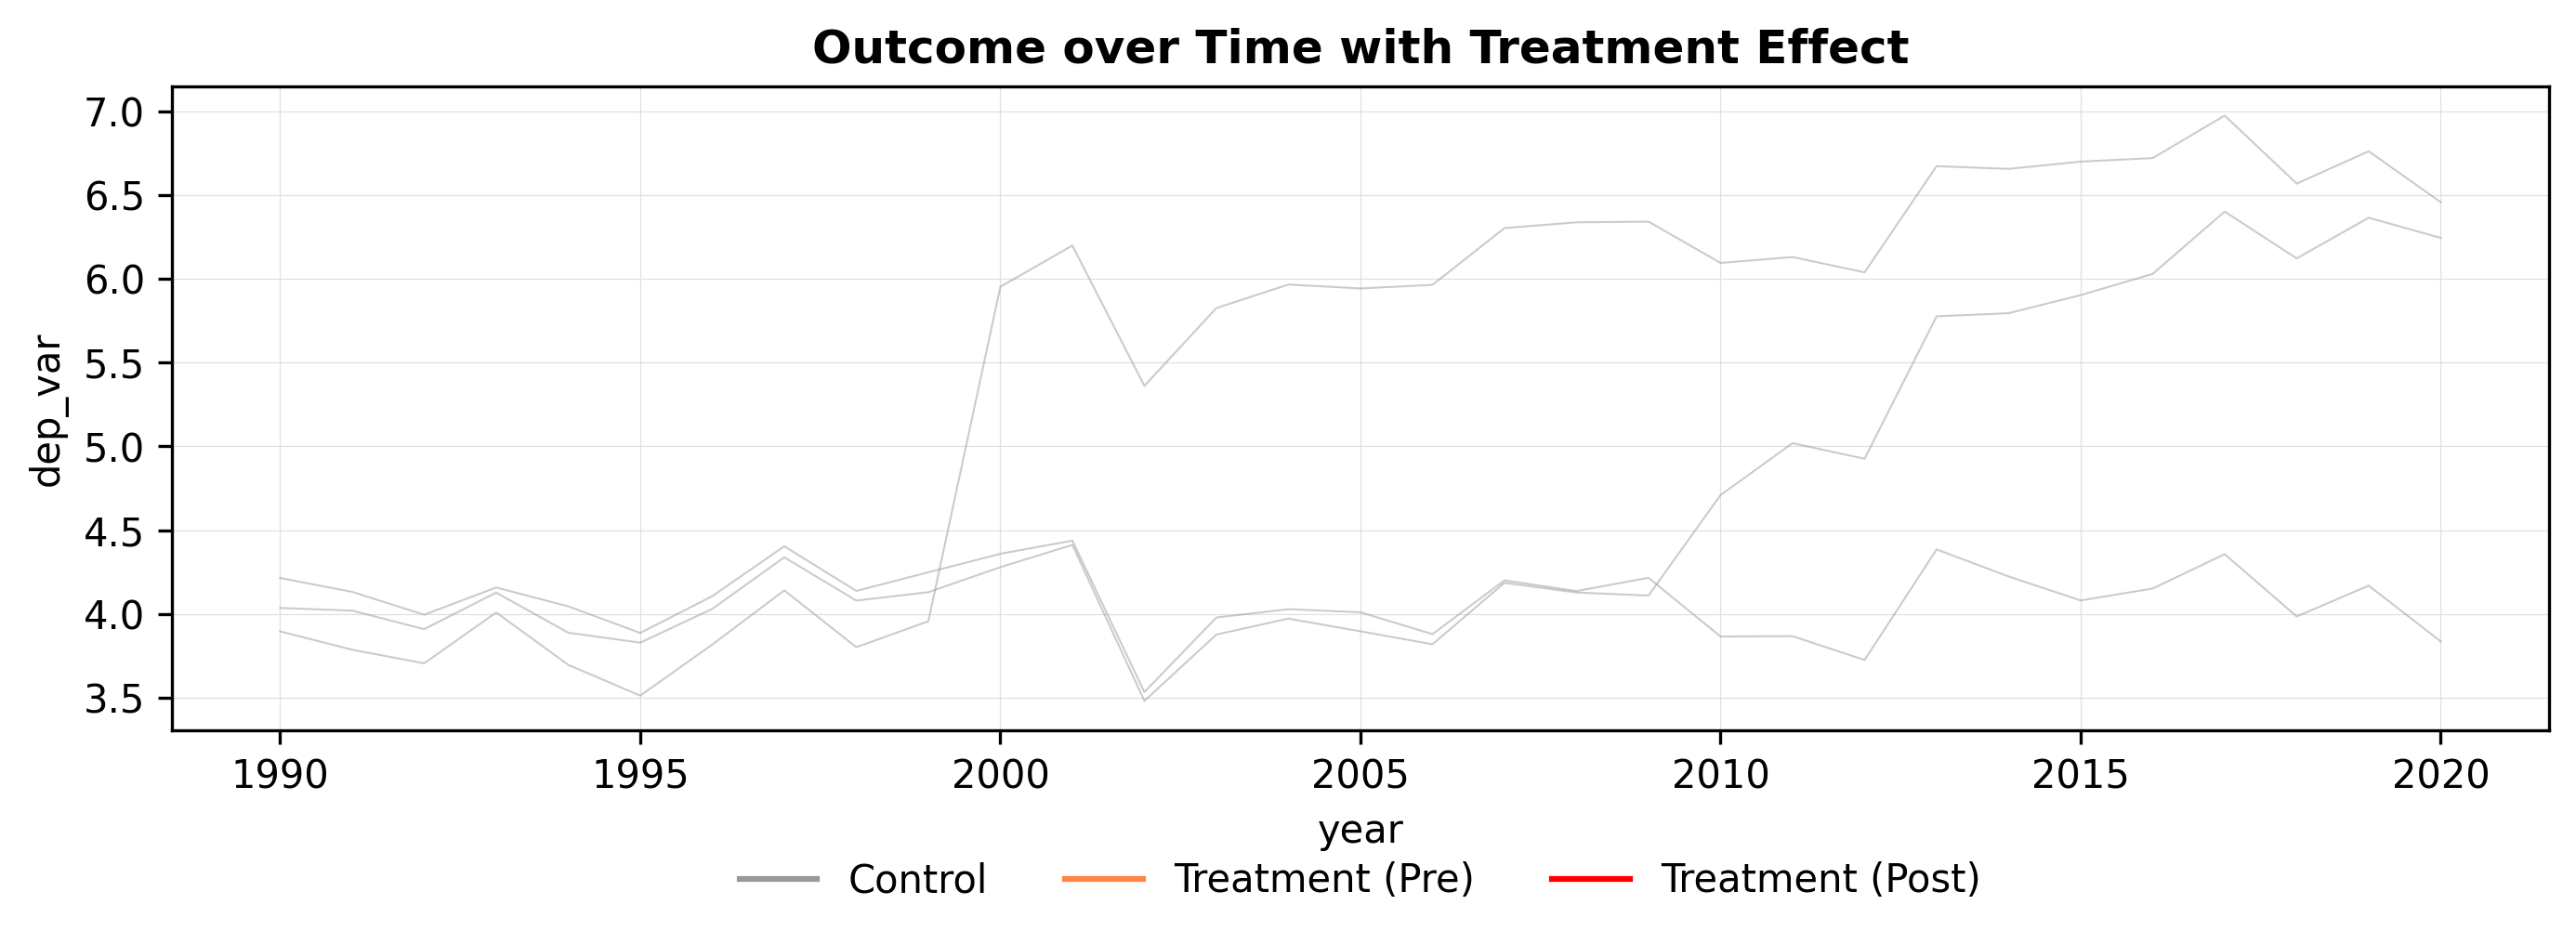

In [7]:
pf.panelview(
    df_multi_cohort,
    outcome="dep_var",
    unit="unit",
    time="year",
    treat="treat",
    collapse_to_cohort=True,
    legend=True,
)

We immediately see that the first cohort is switched into treatment in 2000, while the second cohort is switched into treatment by 2010. 
Before each cohort is switched into treatment, the trends are parallel.

We can additionally inspect individual units by dropping the collapse_to_cohort argument. Because we have a large sample, we might want to inspect only a subset 
of units. 

<Axes: title={'center': 'Outcome over Time with Treatment Effect'}, xlabel='year', ylabel='dep_var'>

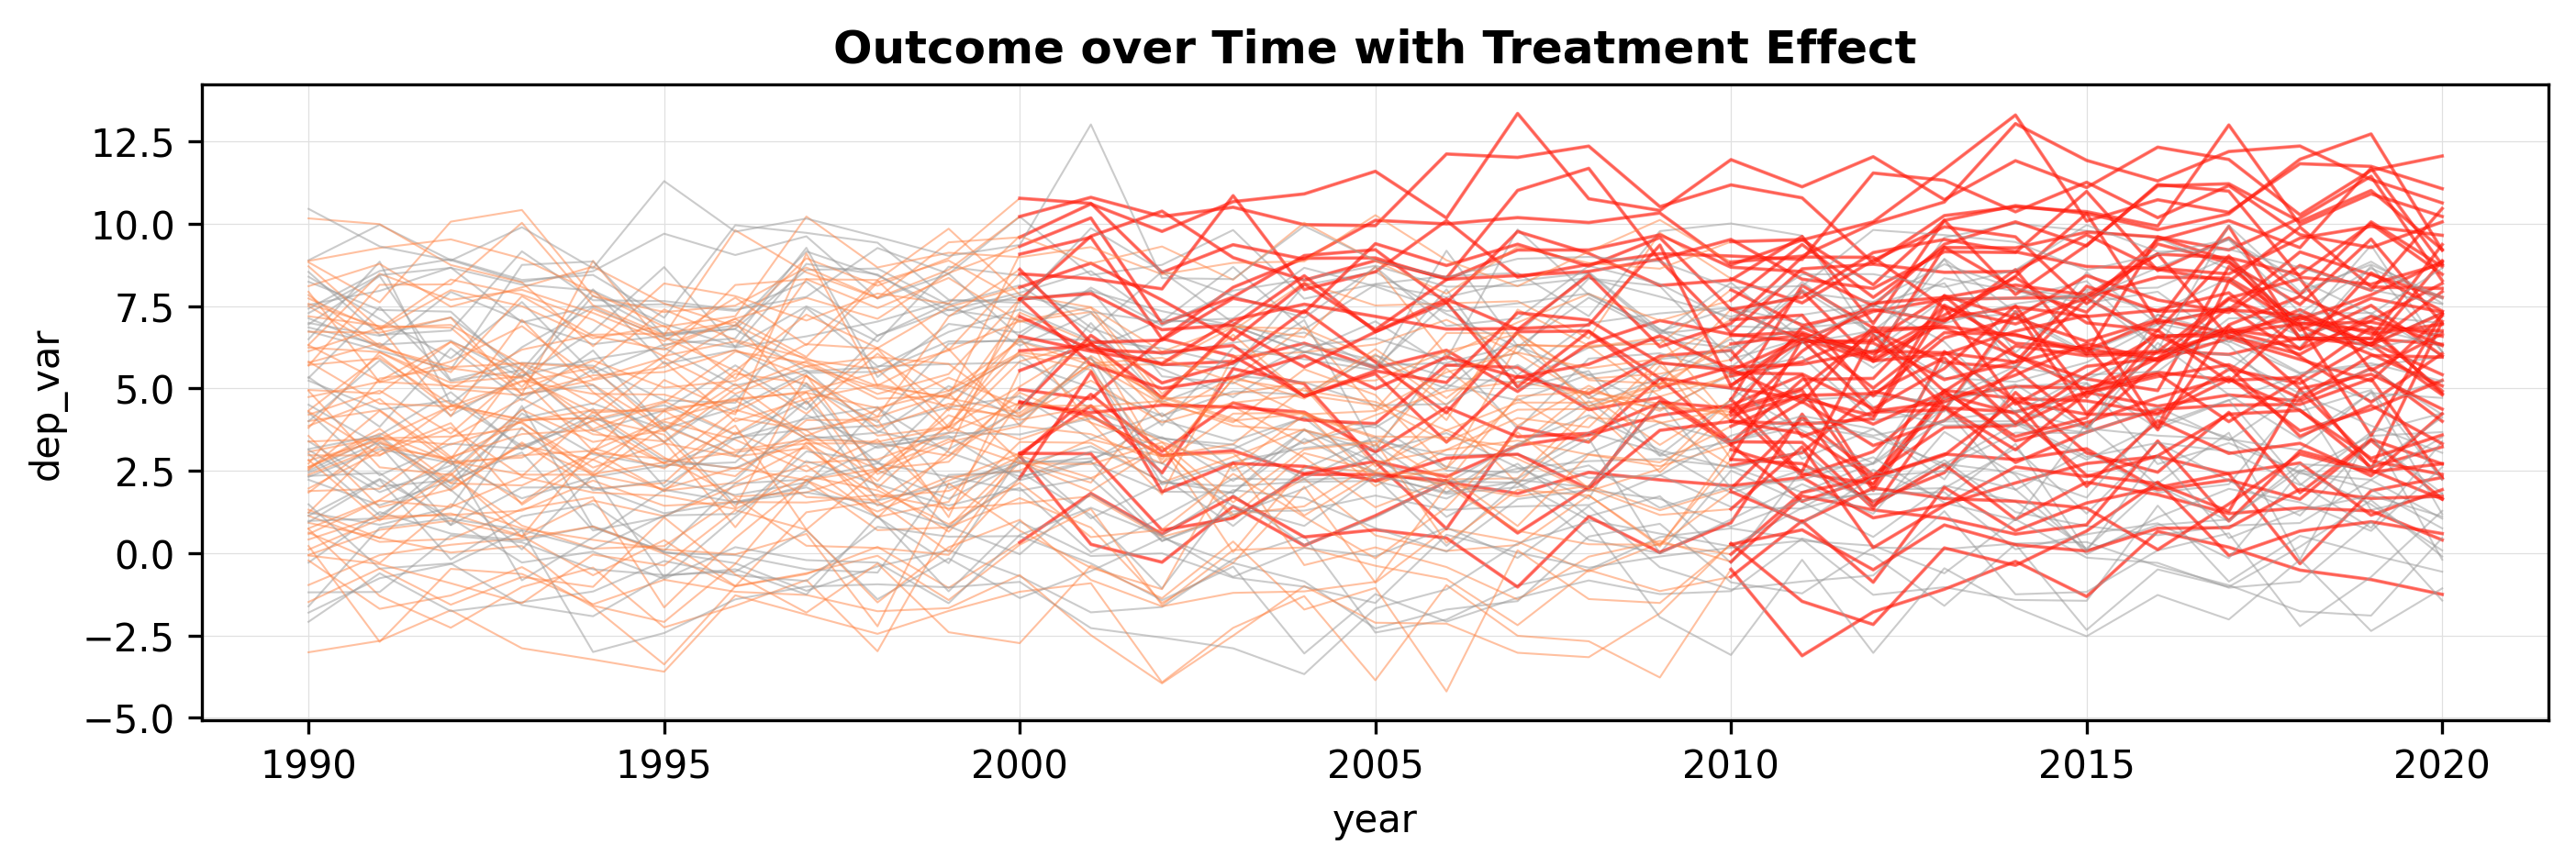

In [8]:
pf.panelview(
    df_multi_cohort,
    outcome="dep_var",
    unit="unit",
    time="year",
    treat="treat",
    subsamp=100,
)

### One-shot adoption: Static and Dynamic Specifications

After taking a first look at the data, let's turn to estimation. We return to the `df_one_cohort` data set (without staggered treatment rollout).

In [9]:
fit_static_twfe = pf.feols(
    "Y ~ treat | unit + year",
    df_one_cohort,
    vcov={"CRV1": "unit"},
)
fit_static_twfe.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: unit+year
Inference:  CRV1
Observations:  30000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| treat         |      0.206 |        0.052 |     3.929 |      0.000 |  0.103 |   0.308 |
---
RMSE: 0.701 R2: 0.905 R2 Within: 0.003 


Since this is a single-cohort dataset, this estimate is consistent for the ATT under parallel trends. We can estimate heterogeneous effects by time by interacting time with the treated group:

In [10]:
fit_dynamic_twfe = pf.feols(
    "Y ~ i(year, ever_treated,  ref = 14) | unit + year",
    df_one_cohort,
    vcov={"CRV1": "unit"},
)

In [11]:
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Event Study",
    figsize=[1200, 400],
    yintercept=0,
    xintercept=13.5,
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
)

Event study plots like this are very informative, as they allow us to visually inspect the parallel trends assumption and also the dynamic effects of the treatment. 

Based on a cursory glance, one would conclude that parallel trends does not hold because one of the pre-treatment coefficient has a confidence interval that does not include zero. However, we know that parallel trends is true because the treatment is randomly assigned in the underlying DGP.

#### Pointwise vs Simultaneous Inference in Event Studies

This is an example of a false positive in testing for pre-trends produced by _pointwise_ inference (where each element of the coefficient vector is tested separately). 

As an alternative, we can use simultaneous confidence bands of the form $[a, b] = ([a_k, b_k])_{k=1}^K$ such that 

$$
P(\beta \in [a, b]) = P(\beta_k \in [a_k, b_k] \forall k) \rightarrow 1 - \alpha
$$

These bands can be constructed by using a carefully chosen critical value $c$ that [accounts for the covariance between coefficients using the multiplier bootstrap](https://www.annualreviews.org/docserver/fulltext/statistics/10/1/annurev-statistics-040120-022239.pdf?expires=1724543273&id=id&accname=guest&checksum=0D11ADF816FFFA0AE21BD7EDC6DB1801#page=14). In pointwise inference, the critical value is $c = z_{1 - \alpha/2} = 1.96$ for $\alpha = 0.05$; the corresponding critical value for simultaneous inference is typically larger. These are also known as `sup-t` bands in the literature (see lec 3 of the NBER SI methods lectures linked above). 

This is implemented in the `confint(joint=True)` method in the `feols` class. If we pass the `joint='both'` argument to `iplot`, we get the simultaneous confidence bands (for all event study coefficients) in addition to the pointwise confidence intervals. Note that simultaneous inference for all event study coefficients may be overly conservative, especially when the number of coefficients is large; one may instead choose to perform joint inference for [all pre-treatment coefficients and all post-treatment coefficients separately](https://gist.github.com/apoorvalal/8a7687d3620577fd5214f1d43fc740b3).

In [12]:
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Event Study",
    figsize=[1200, 400],
    yintercept=0,
    xintercept=13.5,
    joint="both",
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
)

The joint confidence bands are wider than the pointwise confidence intervals, and they include zero for all pre-treatment coefficients. This is consistent with the parallel trends assumption.

### Event Study under Staggered Adoption via `feols()`, `did2s()` and `lpdid()`

We now return to the data set with staggered treatment rollout, `df_multi_cohort`.

As a baseline model, we can estimate a simple two-way fixed effects DiD regression via `feols()`:

In [13]:
fit_twfe = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year",
    df_multi_cohort,
    vcov={"CRV1": "state"},
)

To do the same via Gardners 2-stage estimator, we employ the the `did2s()` function: 

In [14]:
fit_did2s = pf.did2s(
    df_multi_cohort,
    yname="dep_var",
    first_stage="~ 0 | state + year",
    second_stage="~i(rel_year,ref=-1.0)",
    treatment="treat",
    cluster="state",
)

Last, we can estimate the ATT for each time period via local projections by using the `lpdid()` function: 

In [15]:
fit_lpdid = pf.lpdid(
    data=df_multi_cohort,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=False,
)

Let's look at some results: 

In [16]:
figsize = [1200, 400]

In [17]:
fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
    labels=rename_event_study_coefs(fit_twfe._coefnames),  # rename coefficients
).show()

In [18]:
fit_did2s.iplot(
    coord_flip=False,
    title="DID2s-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
    labels=rename_event_study_coefs(fit_twfe._coefnames),
).show()

In [19]:
fit_lpdid.iplot(
    coord_flip=False,
    title="Local-Projections-Estimator",
    figsize=figsize,
    yintercept=0,
    xintercept=18.5,
).show()

What if we are not interested in the ATT per treatment period, but in a pooled effects? 

In [20]:
fit_twfe = pf.feols(
    "dep_var ~ i(treat) | unit + year",
    df_multi_cohort,
    vcov={"CRV1": "state"},
)

fit_did2s = pf.did2s(
    df_multi_cohort,
    yname="dep_var",
    first_stage="~ 0 | unit + year",
    second_stage="~i(treat)",
    treatment="treat",
    cluster="state",
)

fit_lpdid = pf.lpdid(
    data=df_multi_cohort,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=True,
)
pd.concat(
    [
        fit_twfe.tidy().assign(estimator="TWFE"),
        fit_did2s.tidy().assign(estimator="DID2s"),
        fit_lpdid.tidy().assign(estimator="LPDID").drop("N", axis=1),
    ],
    axis=0,
)

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%,estimator
C(treat)[T.True],1.982540,0.019331,102.556180,0.0,1.943439,2.021642,TWFE
C(treat)[T.True],2.230482,0.024709,90.271437,0.0,2.180504,2.280460,DID2s
treat_diff,2.506746,0.071357,35.129648,0.0,2.362413,2.651080,LPDID
